In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

### Daily

In [ ]:
# Read in daily data
df = pd.read_parquet('data/TX_AUS.parquet')
df = df.rename(columns={'invoice_date': 'ds', 'sale_value': 'y'})
df.index.names = ['ds']
df = df['2020-03-21':]
df.head()

,y
ds,
2020-03-21,10781
2020-03-22,14112
2020-03-23,17443
2020-03-24,9439
2020-03-25,22995


In [ ]:
# Split the data into training and testing sets
train, test = df[:'2021-08-16'], df['2021-08-16':]

# Create the ARIMA model With daily data
daily_arima = ARIMA(train, order=(2,1,1))
daily_arima = daily_arima.fit()

# Get the forecast for test data
daily_forecast = daily_arima.get_forecast(steps = len(test))
daily_forecast_conf = daily_forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Create the DataFrame
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},  # Corrected here
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])

# Convert to datetime
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])

# Calculate the upper window
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# Display the updated DataFrame
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [ ]:
# Split the data into training and testing sets
train, test = df[:'2021-08-16'], df['2021-08-16':]
train = train.reset_index()
test = test.reset_index()

# Create prophet model
model_daily = Prophet(daily_seasonality=False, holidays=lockdowns)
model_daily = model_daily.fit(train)
future = model_daily.make_future_dataframe(periods=len(test) - 1)
prediction_daily = model_daily.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3oj4s7zl/n8vdv_fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3oj4s7zl/bfthragx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93060', 'data', 'file=/tmp/tmp3oj4s7zl/n8vdv_fv.json', 'init=/tmp/tmp3oj4s7zl/bfthragx.json', 'output', 'file=/tmp/tmp3oj4s7zl/prophet_modelq5xsfef1/prophet_model-20241127021556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:15:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:15:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


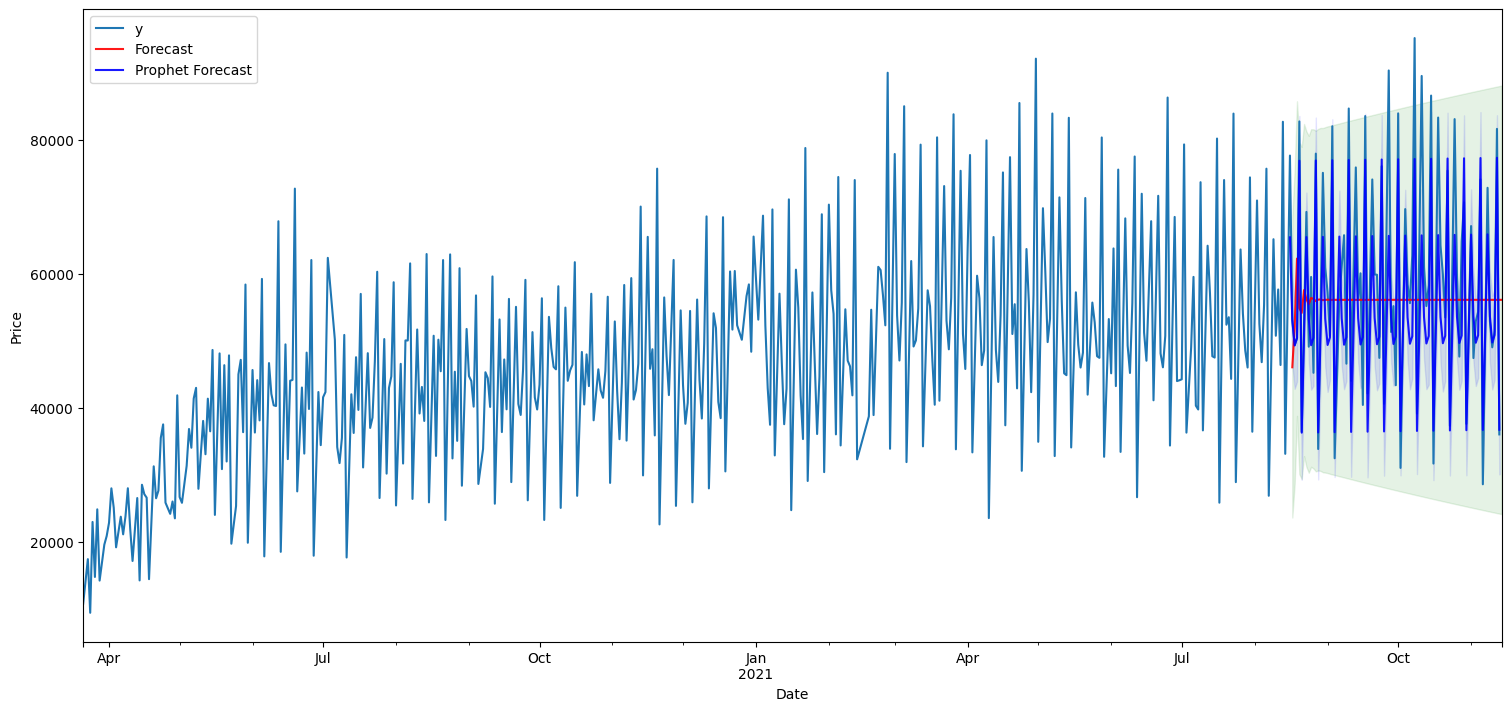

In [ ]:
# Plot observed values
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax = df['y'].plot()

# Plot forecasted values
daily_forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.9)

# Plot the range for ARIMA confidence intervals
ax.fill_between(daily_forecast_conf.index,
                daily_forecast_conf.iloc[:, 0],
                daily_forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Plot prophet forecasted values
prediction_daily = prediction_daily.set_index('ds')['2021-08-16':]
prediction_daily.index = df['2021-08-16':].index
prediction_daily['yhat'].plot(ax=ax, label='Prophet Forecast', color='blue', alpha=0.9)

# Plot prophet confidence interval
ax.fill_between(prediction_daily.index,
                prediction_daily['yhat_lower'],
                prediction_daily['yhat_upper'], color='b', alpha=0.1)


# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [ ]:
rmse(prediction_daily['yhat'][-len(test):], test['y'])

8153.107127258772

### Weekly

In [ ]:
# Read in daily data
df = pd.read_parquet('data/TX_AUS.parquet')
df = df.rename(columns={'invoice_date': 'ds', 'sale_value': 'y'})
df.index.names = ['ds']
df = df['2020-03-21':]
df.head()

,y
ds,
2020-03-21,10781
2020-03-22,14112
2020-03-23,17443
2020-03-24,9439
2020-03-25,22995


In [ ]:
# Aggregate by weekly mean
dt = df.copy()
dt = dt['y'].resample('W').mean()
dt = pd.DataFrame(dt)
dt.head()

,y
ds,
2020-03-22,12446.500000
2020-03-29,17245.142857
2020-04-05,22460.285714
2020-04-12,22545.714286
2020-04-19,22925.571429


In [ ]:
# Split the data into training and testing sets
train, test = dt[:'2021-08-16'], dt['2021-08-16':]

# Create the ARIMA model with weekly data
weekly_arima = ARIMA(train, order=(0,1,1))
weekly_arima = weekly_arima.fit()

# Get the forecast for test data
weekly_forecast = weekly_arima.get_forecast(steps = len(test))
weekly_forecast_conf = weekly_forecast.conf_int()

In [ ]:
# Split the data into training and testing sets
train, test = dt[:'2021-08-16'], dt['2021-08-16':]
train = train.reset_index()
test = test.reset_index()

# Create Prophet model
model_weekly = Prophet(daily_seasonality=False, holidays=lockdowns)
model_weekly = model_weekly.fit(train)
future = model_weekly.make_future_dataframe(periods=len(test))
prediction_weekly = model_weekly.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3oj4s7zl/h9qkc_hc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3oj4s7zl/_4sdxyha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81338', 'data', 'file=/tmp/tmp3oj4s7zl/h9qkc_hc.json', 'init=/tmp/tmp3oj4s7zl/_4sdxyha.json', 'output', 'file=/tmp/tmp3oj4s7zl/prophet_model23xu1l0x/prophet_model-20241127021559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:16:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


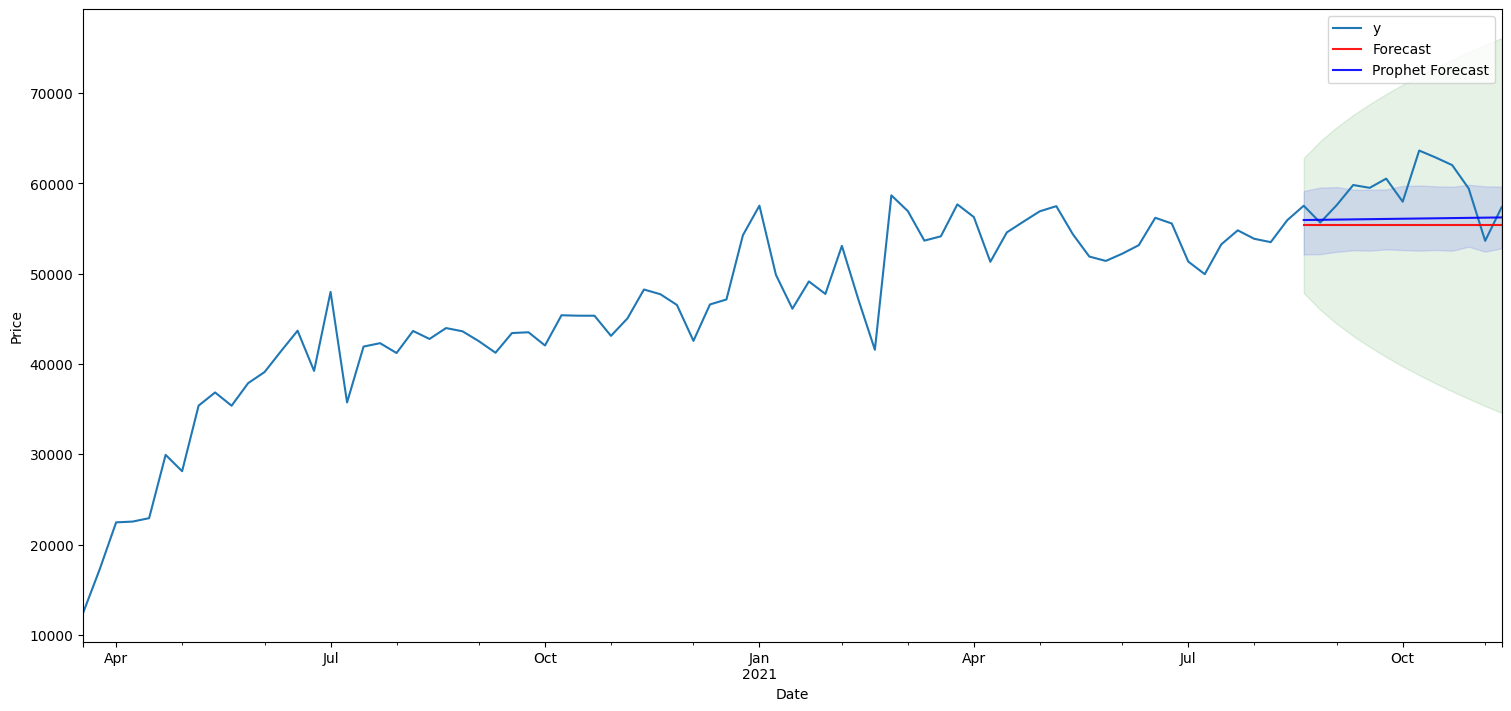

In [ ]:
# Plot observed values
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')
ax = dt['y'].plot()

# Plot forecasted values
weekly_forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(weekly_forecast_conf.index,
                weekly_forecast_conf.iloc[:, 0],
                weekly_forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Plot prophet forecasted values
prediction_weekly = prediction_weekly.set_index('ds')['2021-08-16':]
prediction_weekly.index = dt['2021-08-16':].index
prediction_weekly['yhat'].plot(ax=ax, label='Prophet Forecast', color='blue', alpha=0.9)

# Plot prophet confidence interval
ax.fill_between(prediction_weekly.index,
                prediction_weekly['yhat_lower'],
                prediction_weekly['yhat_upper'], color='b', alpha=0.1)


# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [ ]:
rmse(prediction_weekly['yhat'][-len(test):], test['y'])

4019.4597720175534